# APRENDIZAJE AUTOMÁTICO
# Práctica 1: Regresión
### Autor: Herce Cruz, Daniel
### NIP:   848884
### Fecha: 01-02-2024

---



## Configuración

In [355]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab")
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/UNIVERSIDAD_DRIVE/3_curso/Aprendizaje_automatico/Practicas_AA/Practica_1/' # Directorio donde guardas los ficheros
except:
  print("Trabajando en local")
  Path = ''                                    # Directorio donde guardas los ficheros

Trabajando en local


---
## 0. Visualización de datos

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


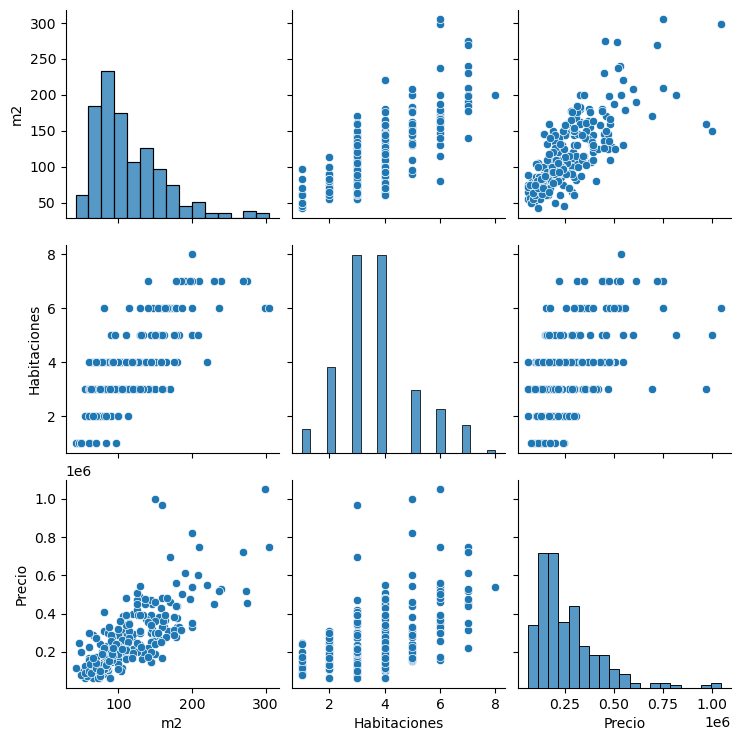

In [356]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# Leer los ficheros de datos y pasarlos a matrices de numpy
pisos_train = pd.read_csv(Path+'PisosTrain.csv', sep = ";")
x1_train = pisos_train["m2"].to_numpy().reshape(-1, 1)
x2_train = pisos_train["Habitaciones"].to_numpy().reshape(-1, 1)
y_train  = pisos_train["Precio"].to_numpy()

pisos_test  = pd.read_csv(Path+'PisosTest.csv',  sep = ";")
x1_test = pisos_test["m2"].to_numpy().reshape(-1, 1)
x2_test = pisos_test["Habitaciones"].to_numpy().reshape(-1, 1)
y_test  = pisos_test["Precio"].to_numpy()

# Mostrar los datos de entrenamiento
seaborn.pairplot(pisos_train)
plt.show()

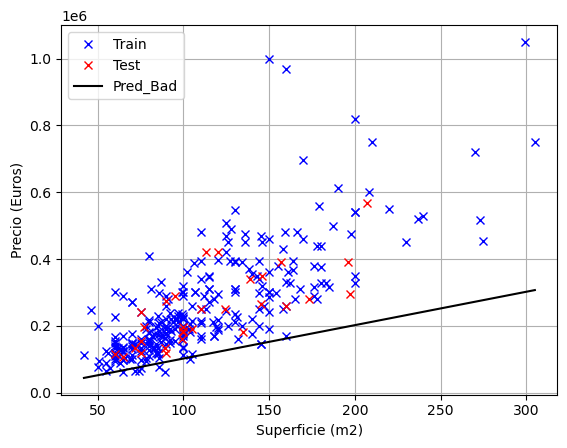

In [357]:
# Ejemplo de dibujo de un atributo y una prediccion inventada
x1_grid = np.linspace(np.min(x1_train), np.max(x1_train), 100).reshape(-1, 1)
y_grid_pred = x1_grid *1000 + 2000  # Prediccion inventada

plt.figure()
plt.plot(x1_train, y_train, 'bx', label='Train')
plt.plot(x1_test, y_test,  'rx', label='Test')
plt.plot(x1_grid, y_grid_pred, 'k-', label='Pred_Bad')
plt.xlabel('Superficie (m2)')
plt.ylabel('Precio (Euros)')
plt.legend()
plt.grid()
plt.show()

Se puede observar que la relación entre las la superficie y el precio es lineal aunque hay mucha dispersión en los datos. Además, se pueden observar datos espurios en los datos de entrenamiento con precios muy elevados.

---
## 1. Métricas

Para evaluar el modelo se utilizarán las siguientes métricas:

- R2: Coeficiente de determinación.
    >Indica que parte de la varianza de y es explicada por el modelo. Siempre es recomendable utilizarlo para evaluar modelos de regresión.
- MAE: Error absoluto medio.
    >Es la media de la diferencia absoluta entre los valores predichos y los valores reales. Es una métrica menos afectada por valores espurios.
- MRE: Error relativo medio.
    >Es la media de la diferencia relativa entre los valores predichos y los valores reales. Igual que la anterior pero en porcentaje.
- MedAE: Error absoluto mediano.
    >Es la mediana de la diferencia absoluta entre los valores predichos y los valores reales. Es una métrica menos afectada por valores espurios, aunque aquí el número de datos espurios es bajo puede ser interesante utilizarla.

In [358]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, r2_score

results = pd.DataFrame()  # Variable global con la tabla de resultados

## Función para añadir las métricas de un modelo a la tabla de resultados
def addMetricsToResults(label, y_train, y_train_pred, y_test, y_test_pred, results_var=None, displayMetric=True):
    """
    Función que calcula diversas métricas de evaluación de un modelo de aprendizaje automático
    y las agrega a una tabla de resultados global.

    Parámetros:
    - label: Etiqueta para identificar el modelo.
    - y_train: Valores reales del conjunto de entrenamiento.
    - y_train_pred: Valores predichos por el modelo para el conjunto de entrenamiento.
    - y_test: Valores reales del conjunto de prueba.
    - y_test_pred: Valores predichos por el modelo para el conjunto de prueba.

    Retorna:
    No retorna ningún valor, pero agrega una fila con las métricas calculadas a la tabla de resultados global.
    """
    global results
    
    nextRes = pd.DataFrame(
        {"Label": label,
        "R2_train"  :  [r2_score(y_train, y_train_pred)],
        "MAE_train":   [mean_absolute_error(y_train, y_train_pred)],
        "MRE_train":   [mean_absolute_percentage_error(y_train, y_train_pred)],
        "MedAE_train": [median_absolute_error(y_train, y_train_pred)],

        "R2_test"  :  [r2_score(y_test, y_test_pred)],
        "MAE_test":   [mean_absolute_error(y_test, y_test_pred)],
        "MRE_test":   [mean_absolute_percentage_error(y_test, y_test_pred)],
        "MedAE_test": [median_absolute_error(y_test, y_test_pred)],
        })
    
    if displayMetric:
        display(nextRes)

    if results_var is not None:
        # Añadir la fila a la tabla de resultados, concat() devuelve una nueva tabla con la fila añadida
        results_var = pd.concat([results_var, nextRes], ignore_index=True) #ignore_index=True para que el índice de las filas sea consecutivo y no repita valores, si es False (por defecto) el índice de las filas es el de los dataframes que se concatenanç
        return results_var
    else:
        results = pd.concat([results, nextRes], ignore_index=True)
    

In [359]:
def eval_model(model, x_train, y_train, x_test, y_test):
    """
    Función que evalúa un modelo de regresión lineal multivariable con descenso de gradiente estocástico
    y muestra
    - Las métricas de evaluación
    - Los coeficientes de la función de predicción
    - Un gráfico 3D con los datos de entrenamiento y test y el plano de predicción
    - Un gráfico 2D con las predicciones y los datos reales

    Parámetros:
    - model: Modelo de regresión lineal multivariable con descenso de gradiente estocástico.
    - x_train: Datos de entrenamiento.
    - y_train: Valores reales del conjunto de entrenamiento.
    - x_test: Datos de test.
    - y_test: Valores reales del conjunto de prueba.
    
    Retorna:
    Los valores predichos para el conjunto de entrenamiento y el conjunto de test.
    """
      
    # Dibujar la ecuación del plano de predicción y los puntos de entrenamiento en 3D
    # Código generado con GitHub Copilot
    plt.figure()
    ax = plt.axes(projection='3d')  # Crear un objeto de tipo Axes3D para dibujar en 3D
    ax.scatter(x_train[:,0], x_train[:,1], y_train, c='b', label='Train')
    ax.scatter(x_test[:,0], x_test[:,1], y_test, c='r', label='Test')
    
    x1_grid, x2_grid = np.meshgrid(np.linspace(np.min(x_train[:,0]), np.max(x_train[:,0]), 100),
                                      np.linspace(np.min(x_train[:,1]), np.max(x_train[:,1]), 100))
    y_grid_pred = model.predict(np.c_[x1_grid.ravel(), x2_grid.ravel()]).reshape(x1_grid.shape)

    ax.plot_surface(x1_grid, x2_grid, y_grid_pred, alpha=0.5, color='g', label='Pred')

    ax.set_xlabel('Superficie (m2)')
    ax.set_ylabel('Habitaciones')
    ax.set_zlabel('Precio (Euros)')

    plt.show()

    # Dibujar las predicciones en 2D para visualizar los residuos
    # Para mostrar 3 gráficas en una fila
    fig, axs = plt.subplots(1, 3, figsize=(15, 5)) # 1 fila, 3 columnas


    # Generar las predicciones
    y_train_pred = model.predict(x_train)
    y_test_pred  = model.predict(x_test)

    # Dibujar los datos de entrenamiento y test
    axs[0].plot(y_test, y_test_pred, 'rx', label='Test')
    axs[0].plot(y_train, y_train_pred, 'bx', label='Train')
    axs[0].set_title('Test and Train')

    # Dibujar solo los datos de entrenamiento
    axs[1].plot(y_train, y_train_pred, 'bx', label='Train')
    axs[1].set_title('Train')

    # Dibujar solo los datos de test
    axs[2].plot(y_test, y_test_pred, 'rx', label='Test')
    axs[2].set_title('Test')

    # Poner los x e y labels en todas las gráficas
    for ax in axs:
        # Dibujar la prección perfecta = diagonal
        # Para ello, dibujamos una línea recta entre el punto (0,0) y el punto (ymax, ymax)
        # esto se hace con la función plot([x1, x2], [y1, y2])
        ax.plot([0, np.max(y_train)], [0, np.max(y_train)], 'k-', label='Pred_Perfect')
        ax.set_xlabel('Precio real (Euros)')
        ax.set_ylabel('Precio predicho (Euros)')
        ax.grid() # Mostrar la rejilla
        ax.legend()

    plt.show()

    return y_train_pred, y_test_pred

### Referencias:
https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

----
## 2. Regresión Monovariable

Este es un modelo de **regresión monovariable** que predice el precio de los pisos en función únicamente de su superficie, utilizando mínimos cuadrados convencionales (ecuación normal).

### 2.1. Entrenamiento

In [360]:
from sklearn import linear_model

# No hace falta escalar los datos porque solo hay una variable

# Entrenar el modelo
regrMono = linear_model.LinearRegression()
regrMono.fit(x1_train, y_train)

# Generar las predicciones
y_train_pred = regrMono.predict(x1_train)
y_test_pred  = regrMono.predict(x1_test)

### 2.2. Evaluación

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,LinearRegression_mono),0.583546,69534.930002,0.300915,50507.312333,0.460891,63936.474539,0.274446,56182.927196


Función de predicción tras el entrenamiento:
f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)
f(x) = (-34313.38797202357, 2608.2094347218) * (1, x1)


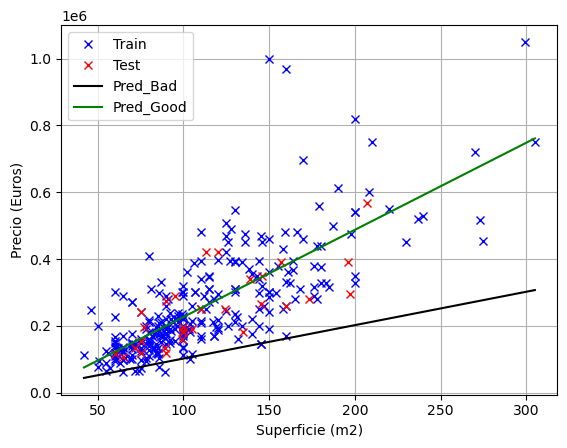

In [361]:
# Añadir las métricas a la tabla de resultados
addMetricsToResults("LinearRegression_mono)", y_train, y_train_pred, y_test, y_test_pred)

# Mostrar los coeficientes
print("Función de predicción tras el entrenamiento:")
print("f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)")
# f(x) = regrMono.coef_ * x + regrMono.intercept_
#regrMono.coef_ es un array de numpy con los coeficientes de la regresión
#regrMono.intercept_ es el término independiente de la regresión
print("f(x) = (" + str(regrMono.intercept_) + ", " + str(regrMono.coef_[0]) + ") * (1, x1)")
# Dibujar las predicciones
plt.figure()
plt.plot(x1_train, y_train, 'bx', label='Train')
plt.plot(x1_test, y_test,  'rx', label='Test')

plt.plot(x1_grid, y_grid_pred, 'k-', label='Pred_Bad')
plt.plot(x1_grid, regrMono.predict(x1_grid), 'g-', label='Pred_Good')

plt.xlabel('Superficie (m2)')
plt.ylabel('Precio (Euros)')
plt.legend()
plt.grid()
plt.show()

### 3.3. Conclusiones

Podemos observar que el modelo se ajusta bastante bien a los datos, aunque hay algunos datos espurios que quedan alejados de la recta de predicción y no se ajustan bien al modelo. Esto es comprensible ya que el modelo es muy simple y no tiene en cuenta otros factores que pueden afectar al precio de los pisos.

En cuanto a las métricas se observa que son muy similares entre los datos de entrenamiento y los de test. Esto se debe a que los datos de entrenamiento son representativos del problema presentado con los de test y no hay datos espurios entre ellos que afecten a las métricas.

En general las métricas son bastante buenas para la simplicidad del modelo con un R2 de aproximadamente 0.5 y un MRE de aproximadamente el 30%. Esto indica que el modelo explica el 50% de la varianza de los datos y que el error medio es del 30% del precio medio de los pisos.

----
## 3. Regresión Multivariable con mínimos cuadrados convencionales (ecuación normal)

Esto es un modelo de **regresión multivariable** que predice el precio de los pisos en función de su superficie y del número de habitaciones, utilizando mínimos cuadrados convencionales (ecuación normal).

La ecuación normal calcula la solución óptima para los datos de entrenamiento, minimizando el error cuadrático medio.

### 3.1. Entrenamiento

In [362]:
# Preparar los datos
x_train = np.concatenate((x1_train, x2_train), axis=1) # axis=1 para concatenar por columnas
x_test  = np.concatenate((x1_test, x2_test), axis=1)

# Escalar los datos
from sklearn.preprocessing import StandardScaler
# Posibles scalers: StandardScaler, MinMaxScaler, RobustScaler, Normalizer, MaxAbsScaler
# MinMaxScaler escala los datos para que el valor mínimo sea 0 y el máximo 1
# RobustScaler escala los datos usando la mediana y el rango intercuartílico, es robusto a outliers
# Normalizer escala los datos para que tengan norma 1
# MaxAbsScaler escala los datos para que el valor máximo sea 1

# Usamos el StandardScaler para que la media de cada atributo sea 0 y la desviación típica sea 1
# Esto es importante para que los atributos tengan el mismo peso en el modelo
scaler = StandardScaler()
# fit_transform() para aprender la media y desviación típica de los datos de entrenamiento y transformarlos
x_train_scaled = scaler.fit_transform(x_train)
# transform() para escalar los datos de test usando la media y desviación típica aprendida en el entrenamiento
x_test_scaled  = scaler.transform(x_test)

# Entrenar el modelo
regrMulti = linear_model.LinearRegression()
regrMulti.fit(x_train, y_train)


LinearRegression()

### 3.2. Evaluación

Función de predicción tras el entrenamiento:
f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)
f(x) = (-12132.908899974369, 3028.744415169624, -18852.830945533595) * (1, x1, x2)


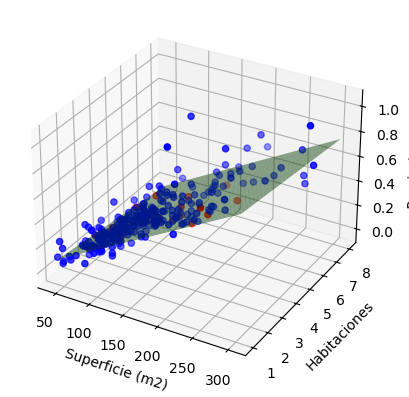

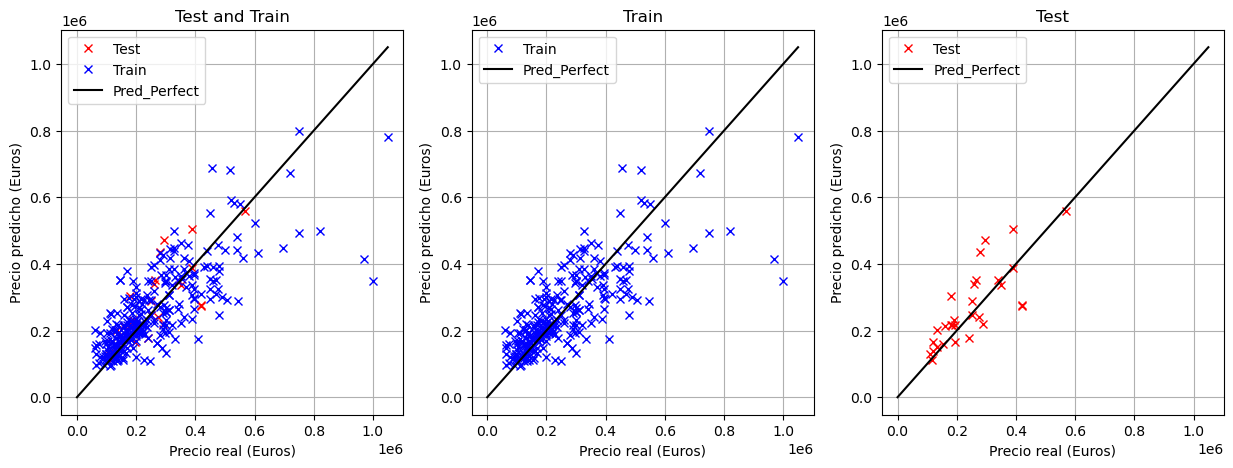

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,LinearRegression_multi,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817


In [363]:
# Mostrar los coeficientes
print("Función de predicción tras el entrenamiento:")
print("f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)")
print("f(x) = (" + str(regrMulti.intercept_) + ", " + str(regrMulti.coef_[0]) + ", " + str(regrMulti.coef_[1]) + ") * (1, x1, x2)")

# Dibujar la ecuación del plano de predicción y los puntos de entrenamiento en 3D
y_train_pred, y_test_pred = eval_model(regrMulti, x_train, y_train, x_test, y_test)

# Añadir las métricas a la tabla de resultados
addMetricsToResults("LinearRegression_multi", y_train, y_train_pred, y_test, y_test_pred)

### 3.3. Conclusiones

Observamos que el modelo mejora las métricas con respecto al modelo monovariable. El R2 aumenta hasta 0.6 y el MRE disminuye hasta el 25%. Esto indica que el modelo explica el 60% de la varianza de los datos y que el error medio es del 25% del precio medio de los pisos.

El añadir una variable más al modelo ha mejorado la capacidad predictiva del mismo, aunque sigue habiendo datos espurios que quedan alejados de la recta de predicción y no se ajustan bien al modelo.


---

## 4. Regresión Multivariable con descenso de gradiente estocástico

Esto es un modelo de **regresión multivariable** que predice el precio de los pisos en función de su superficie y del número de habitaciones, utilizando descenso de gradiente estocástico.

El descenso de gradiente se usa cuando el número de datos es muy grande y no se puede calcular la ecuación normal. Por lo que los resultados en entrenamiento deberían ser iguales (si se converge al mínimo global) o muy similares a ligeramente peores (si se converge a un mínimo local) que los obtenidos con la ecuación normal.

### 4.1. Entrenamiento

In [364]:
# Preparar los datos
x_train = np.concatenate((x1_train, x2_train), axis=1) # axis=1 para concatenar por columnas
x_test  = np.concatenate((x1_test, x2_test), axis=1)

# Hacer pipeline para escalar y entrenar el modelo
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

# Crear el pipeline modelo multivariable con descenso de gradiente estocástico
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html
regrMultiSGD = make_pipeline(StandardScaler(), SGDRegressor()) # loss='squared_loss' por defecto
regrMultiSGD.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

### 4.2. Evaluación

Función de predicción tras el entrenamiento:
f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)
f(x) = ([260578.18095384], 140759.82617745, -24441.715438108527) * (1, x1, x2)


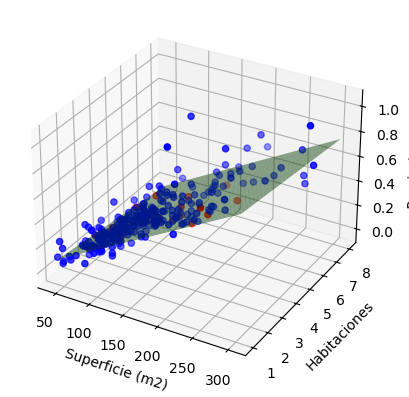

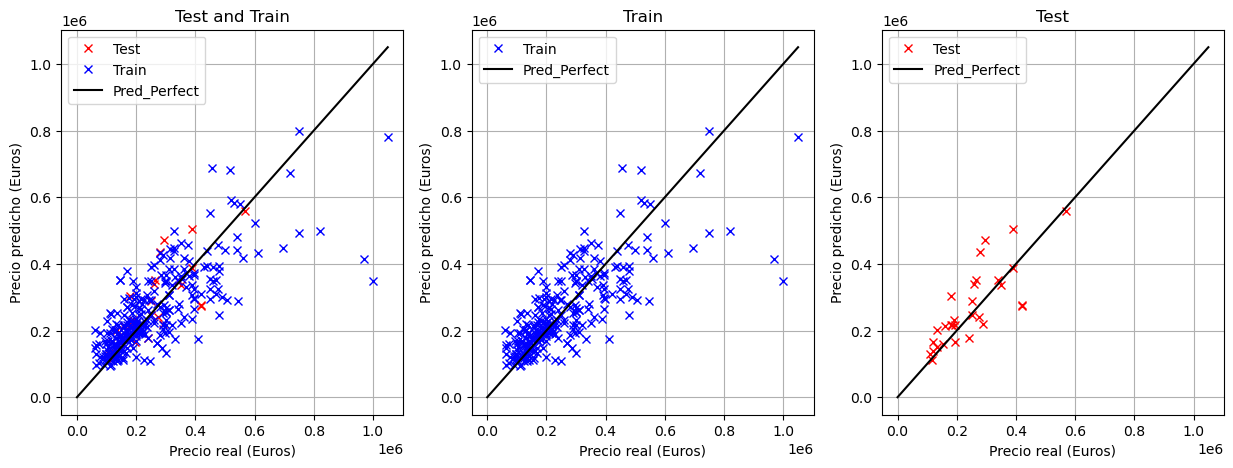

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,SGDRegressor_sqerr,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817


In [365]:
# Mostrar los coeficientes
print("Función de predicción tras el entrenamiento:")
print("f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)")
print("f(x) = (" + str(regrMultiSGD.named_steps['sgdregressor'].intercept_) + ", " + str(regrMultiSGD.named_steps['sgdregressor'].coef_[0]) + ", " + str(regrMultiSGD.named_steps['sgdregressor'].coef_[1]) + ") * (1, x1, x2)")

# Dibujar la ecuación del plano de predicción y los puntos de entrenamiento en 3D
y_train_pred, y_test_pred = eval_model(regrMulti, x_train, y_train, x_test, y_test)
  
# Añadir las métricas a la tabla de resultados
addMetricsToResults("SGDRegressor_sqerr", y_train, y_train_pred, y_test, y_test_pred)

### 4.3. Conclusiones

Es practicamente igual que el modelo anterior, la función de predicción es prácticamente la misma y las métricas son muy similares. Esto es debido a que el descenso de gradiente estocástico ha convergido a un mínimo local que es muy similar al mínimo global que se obtiene con la ecuación normal. Tras ejecutar varias veces el entrenamiento se observa que esto ocurre constantemente. Por lo que no se observa una mejora en el modelo con respecto al modelo anterior.

In [366]:
results

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,LinearRegression_mono),0.583546,69534.930002,0.300915,50507.312333,0.460891,63936.474539,0.274446,56182.927196
1,LinearRegression_multi,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
2,SGDRegressor_sqerr,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817


## 5. Regresión robusta con coste de Huber

Esto es un modelo de **regresión multivariable** que predice el precio de los pisos en función de su superficie y del número de habitaciones, utilizando descenso de gradiente estocástico con coste de Huber.

Con coste cuadrático los datos espurios afectan mucho al modelo, ya que el coste cuadrático penaliza mucho los errores grandes. Con coste de Huber se penalizan menos los errores grandes, por lo que el modelo es más robusto a datos espurios.


### 5.1. Entrenamiento

Los datos con residuo mayor que delta influyen poco. Para conseguir un buen modelo se debe ajustar delta.

In [367]:
# Probamos distintos valores de epsilon para ver cual funciona mejor
# uso de logs para ver mejor los valores: logspace()
epsilons = np.logspace(3, 10, 10)
print(epsilons)

results_aux = pd.DataFrame()  # Variable local con la tabla de resultados

for ep in epsilons:
    regrMultiSGD = make_pipeline(StandardScaler(), SGDRegressor(loss = 'huber', epsilon=ep, penalty=None, max_iter=100000))
    regrMultiSGD.fit(x_train, y_train)

    # Generamos las predicciones
    y_train_pred = regrMultiSGD.predict(x_train)
    y_test_pred  = regrMultiSGD.predict(x_test)
    results_aux = addMetricsToResults("SGD con eps="+str(ep)+")", y_train, y_train_pred, y_test, y_test_pred, results_var=results_aux, displayMetric=False)

display(results_aux)


[1.00000000e+03 5.99484250e+03 3.59381366e+04 2.15443469e+05
 1.29154967e+06 7.74263683e+06 4.64158883e+07 2.78255940e+08
 1.66810054e+09 1.00000000e+10]


,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,SGD con eps=1000.0),0.584264,67663.644412,0.275301,44912.793694,0.578515,53987.592142,0.213527,41244.908704
1,SGD con eps=5994.8425031894085),0.584605,67676.911781,0.276186,44996.014441,0.577409,54260.107055,0.215393,41291.734017
2,SGD con eps=35938.13663804626),0.582737,67715.773484,0.275912,44054.628409,0.584600,53933.028272,0.213570,40841.869303
3,SGD con eps=215443.46900318866),0.592412,68326.771724,0.292322,47023.370879,0.567234,55008.383229,0.228118,37451.339054
4,SGD con eps=1291549.6650148828),0.595004,69042.620910,0.298014,47827.566397,0.537252,55452.677827,0.230752,36845.702515
5,SGD con eps=7742636.826811277),0.594875,68966.621466,0.297750,48422.894940,0.532909,56058.178389,0.233961,37431.029278
6,SGD con eps=46415888.33612782),0.594969,69011.872501,0.298008,48316.869038,0.536818,55641.207430,0.231832,37030.990962
7,SGD con eps=278255940.2207126),0.594962,69012.693346,0.298023,48221.401388,0.535574,55729.907465,0.232289,37153.521201
8,SGD con eps=1668100537.2000558),0.594962,69009.696282,0.298040,48410.470373,0.536796,55666.434506,0.231991,37064.912475
9,SGD con eps=10000000000.0),0.594983,69001.899908,0.297705,48184.022784,0.538515,55464.059342,0.230770,36714.459661


In [368]:
best_epsilon = epsilons[np.argmax(results_aux['R2_test'])]

regrSGDHuber = make_pipeline(StandardScaler(),SGDRegressor(loss='huber', epsilon = best_epsilon, penalty = None, max_iter = 10000))
regrSGDHuber.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(epsilon=35938.13663804626, loss='huber',
                              max_iter=10000, penalty=None))])

### 5.2. Evaluación

Función de predicción tras el entrenamiento:
f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)
f(x) = ([245149.67193041], 127939.86134236089, -18883.12298642676) * (1, x1, x2)


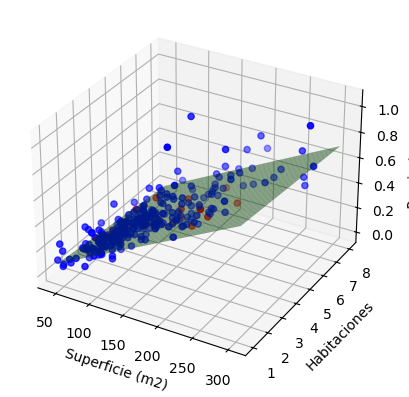

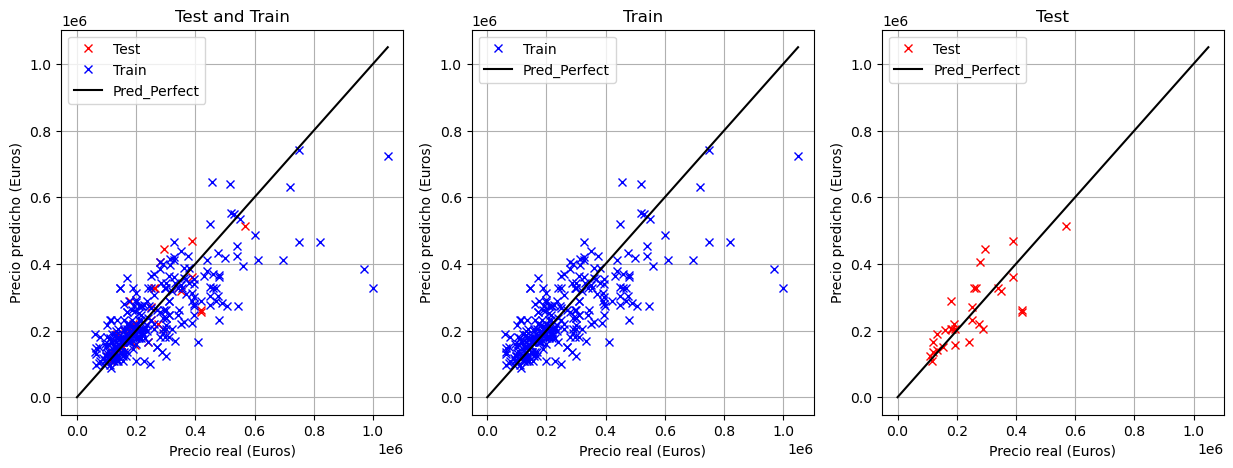

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,SGDRegressor_huber,0.582697,67717.729142,0.275955,44026.988944,0.584717,53941.064888,0.213634,40832.613255


In [369]:
# Mostrar los coeficientes
print("Función de predicción tras el entrenamiento:")
print("f(x) = (w_0, w_1 ... w_D) * (1, x_1, ... x_D)")
print("f(x) = (" + str(regrSGDHuber.named_steps['sgdregressor'].intercept_) + ", " + str(regrSGDHuber.named_steps['sgdregressor'].coef_[0]) + ", " + str(regrSGDHuber.named_steps['sgdregressor'].coef_[1]) + ") * (1, x1, x2)")

y_train_pred, y_test_pred = eval_model(regrSGDHuber, x_train, y_train, x_test, y_test)
addMetricsToResults("SGDRegressor_huber", y_train, y_train_pred, y_test, y_test_pred)

f(x) = (246447.12366132383, 129343.02947654019, -20379.271345180903) * (1, x1, x2)


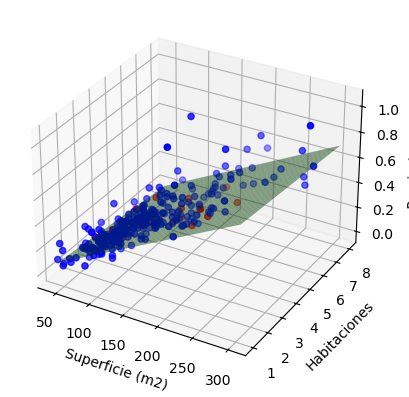

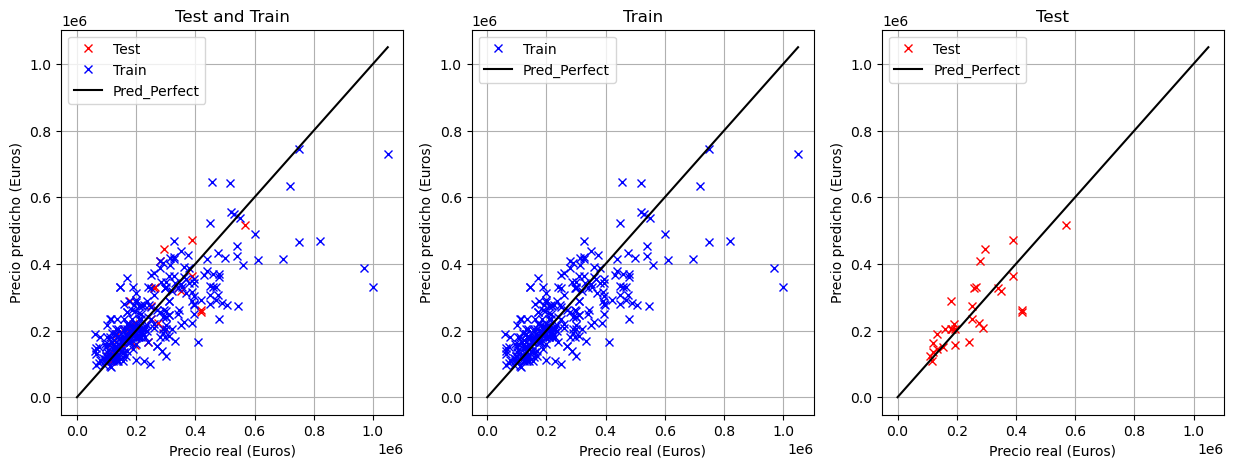

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,HuberRegresor,0.584668,67717.834971,0.27775,44860.835525,0.58649,53636.919864,0.213221,40620.939548


In [370]:
from sklearn.linear_model import HuberRegressor
# Referencia: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html
# Crear el pipeline modelo de regresión con coste de Huber

# delta es ajustado automáticamente
regrHuber = make_pipeline(StandardScaler(), HuberRegressor(max_iter = 10000, alpha = 0))

# Entrenar los modelos
regrHuber.fit(x_train, y_train)

print("f(x) = (" + str(regrHuber.named_steps['huberregressor'].intercept_) + ", " + str(regrHuber.named_steps['huberregressor'].coef_[0]) + ", " + str(regrHuber.named_steps['huberregressor'].coef_[1]) + ") * (1, x1, x2)")

y_train_pred, y_test_pred = eval_model(regrHuber, x_train, y_train, x_test, y_test)
addMetricsToResults("HuberRegresor", y_train, y_train_pred, y_test, y_test_pred)


### 5.3. Conclusiones

In [371]:
results

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,LinearRegression_mono),0.583546,69534.930002,0.300915,50507.312333,0.460891,63936.474539,0.274446,56182.927196
1,LinearRegression_multi,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
2,SGDRegressor_sqerr,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
3,SGDRegressor_huber,0.582697,67717.729142,0.275955,44026.988944,0.584717,53941.064888,0.213634,40832.613255
4,HuberRegresor,0.584668,67717.834971,0.277750,44860.835525,0.586490,53636.919864,0.213221,40620.939548


Observamos como las métricas en training con huber empeoran ligeramente con respecto a los demás pero en test mejoran sustancialmente por lo que el modelo está generalizando mejor. Esto es debido a que el coste de Huber tiene menos en cuenta los datos espurios por lo que el modelo ajustará más la recta de predicción a los datos que no son espurios.

Entre los 2 modelos de huber el implementado con HuberRegresor es sutilmente superior al implementado con descenso de gradiente estocástico con coste de Huber. Esto es debido a que el HuberRegresor ajusta el delta automáticamente para que el modelo generalice mejor y en SGD con coste de Huber se ha ajustado manualmente probando distintos epsilon.

## 6. Redes neuronales

### 6.1. Redes neuronales sin capa oculta

#### 6.1.1. Entrenamiento

In [372]:
# Con scikit-learn
from sklearn.neural_network import MLPRegressor
#solver = 'lbfgs' porque para datasets pequeños es el más rápido
#hidden_layer_sizes = () porque no queremos capas ocultas
#alpha = 0 porque no queremos regularización L2
sck_mlp = MLPRegressor(hidden_layer_sizes=(), solver='lbfgs',)
sck_mlp.fit(x_train, y_train)

MLPRegressor(hidden_layer_sizes=(), solver='lbfgs')

In [373]:
# Con keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError



# Crear el modelo
keras_mlp = Sequential()
# A continuación añadimos la capa de entrada y la capa de salida
keras_mlp.add(Dense(1, input_dim=2, activation='linear'))

# Compilar el modelo
keras_mlp.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=10), metrics=['mean_absolute_error'])

# Entrenar el modelo
# epoch son el número de iteraciones sobre el conjunto de datos. 
keras_mlp.fit(x_train, y_train, epochs=500, verbose=0) 




#### 6.1.2. Evaluación

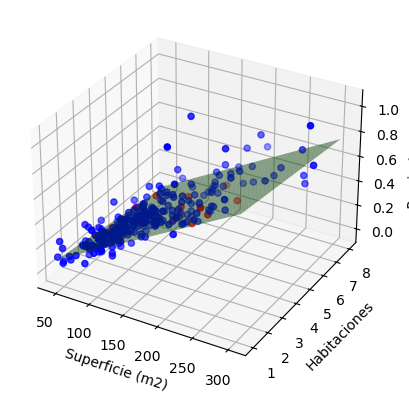

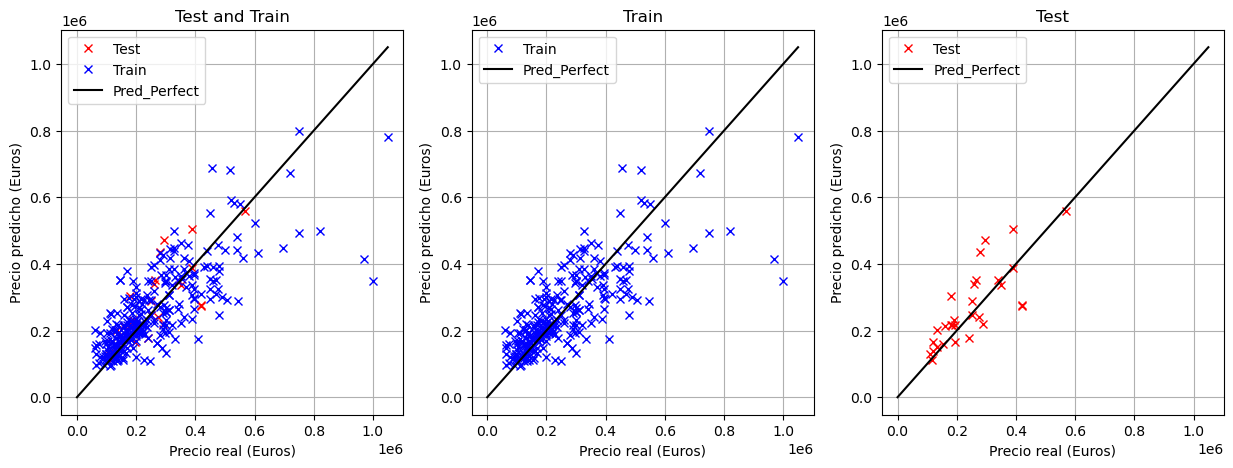

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,MLPRegressor_sck,0.595022,69089.304922,0.298027,48215.890598,0.536754,55256.448041,0.229578,36675.155065


In [374]:
# Evaluación de scikit-learn
y_train_pred, y_test_pred = eval_model(sck_mlp, x_train, y_train, x_test, y_test)
addMetricsToResults("MLPRegressor_sck", y_train, y_train_pred, y_test, y_test_pred)

  1/313 [..............................] - ETA: 8s

313/313 [==============================] - 0s 476us/step


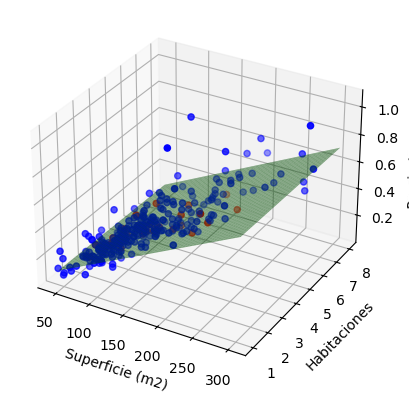

1/1 [==============================] - 0s 12ms/step


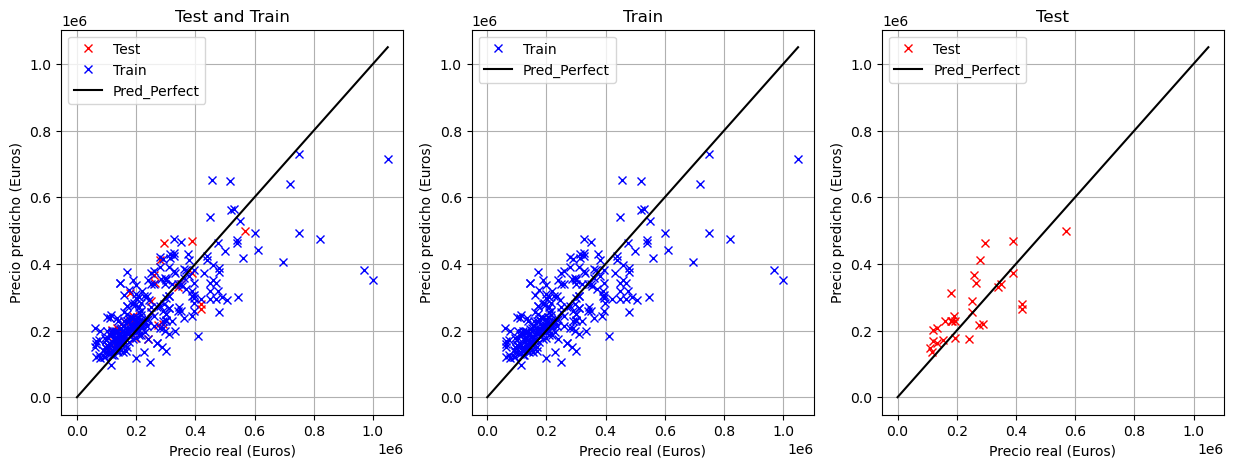

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,Sequential_keras,0.583476,70592.617159,0.31702,53567.046875,0.50287,63503.152604,0.281588,55137.148438


In [375]:
# Evaluación de keras
y_train_pred, y_test_pred = eval_model(keras_mlp, x_train, y_train, x_test, y_test)
addMetricsToResults("Sequential_keras", y_train, y_train_pred, y_test, y_test_pred)


### 6.2. Redes neuronales con capa oculta

#### 6.2.1. Entrenamiento

In [376]:
# Con scikit-learn
# hidden_layer_sizes = (50,) porque queremos una capa oculta con 50 neuronas
sck_mlp2 = MLPRegressor(hidden_layer_sizes=(50,), solver='lbfgs', alpha=0.1)
sck_mlp2.fit(x_train, y_train)

c:\Users\danih\miniconda3\envs\apr24\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0.1, hidden_layer_sizes=(50,), solver='lbfgs')

In [377]:
# Con keras
keras_mlp2 = Sequential()
keras_mlp2.add(Dense(10, input_dim=2, activation='relu')) # Capa oculta
keras_mlp2.add(Dense(1, activation='linear')) # Capa de salida

keras_mlp2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=10), metrics=['mean_absolute_error'])
keras_mlp2.fit(x_train, y_train, epochs=100, verbose=0)

#### 6.2.2. Evaluación

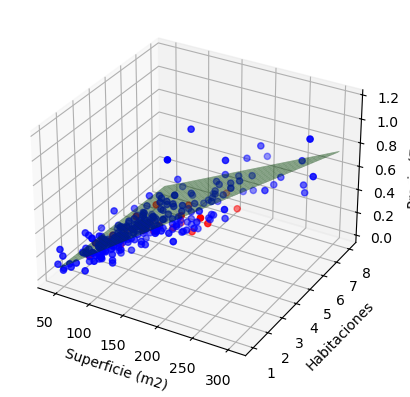

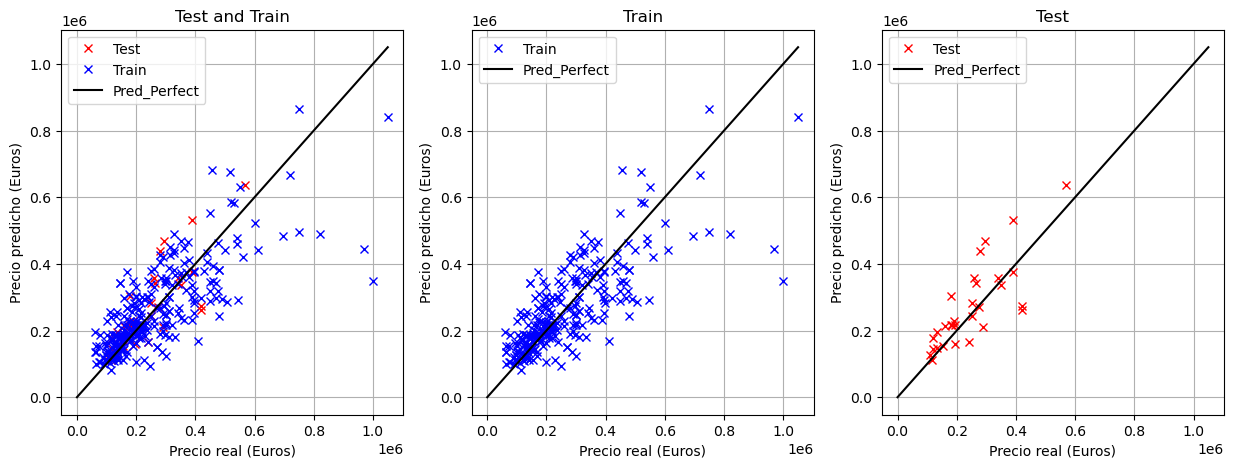

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,MLPRegressor_sck2,0.601002,69171.151342,0.293414,51288.066125,0.47885,59333.388558,0.240543,37975.997767


313/313 [==============================] - 0s 547us/step


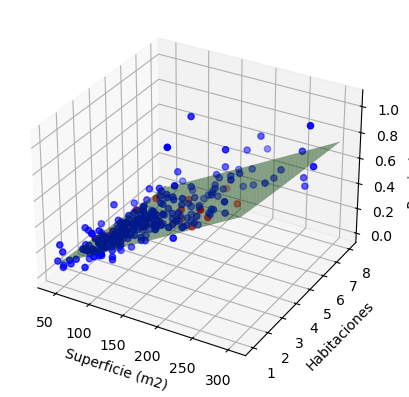

1/1 [==============================] - 0s 13ms/step


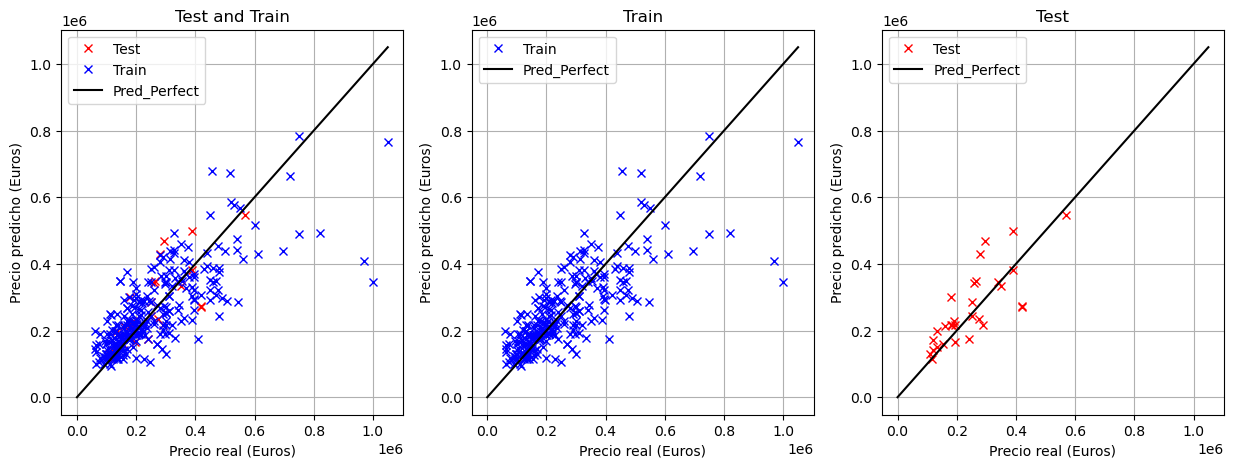

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,Sequential_keras2,0.594607,68720.78694,0.295444,47052.554688,0.54469,55636.439323,0.231475,37023.351562


In [378]:
y_train_pred, y_test_pred = eval_model(sck_mlp2, x_train, y_train, x_test, y_test)
addMetricsToResults("MLPRegressor_sck2", y_train, y_train_pred, y_test, y_test_pred)

y_train_pred, y_test_pred = eval_model(keras_mlp2, x_train, y_train, x_test, y_test)
addMetricsToResults("Sequential_keras2", y_train, y_train_pred, y_test, y_test_pred)

### 6.3. Conclusiones

In [379]:
results

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,LinearRegression_mono),0.583546,69534.930002,0.300915,50507.312333,0.460891,63936.474539,0.274446,56182.927196
1,LinearRegression_multi,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
2,SGDRegressor_sqerr,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
3,SGDRegressor_huber,0.582697,67717.729142,0.275955,44026.988944,0.584717,53941.064888,0.213634,40832.613255
4,HuberRegresor,0.584668,67717.834971,0.277750,44860.835525,0.586490,53636.919864,0.213221,40620.939548
5,MLPRegressor_sck,0.595022,69089.304922,0.298027,48215.890598,0.536754,55256.448041,0.229578,36675.155065
6,Sequential_keras,0.583476,70592.617159,0.317020,53567.046875,0.502870,63503.152604,0.281588,55137.148438
7,MLPRegressor_sck2,0.601002,69171.151342,0.293414,51288.066125,0.478850,59333.388558,0.240543,37975.997767
8,Sequential_keras2,0.594607,68720.786940,0.295444,47052.554688,0.544690,55636.439323,0.231475,37023.351562


Los resultados en ambos casos son mejores con añadiendo una capa oculta. Se nota mucho más en el caso de keras donde la mejora en los datos de test es muy significativa, en el modelo sin capa oculta se observa overfitting al empeorar su predicción en test. Sin embargo al añadir una capa oculta se observa una mejora en la predicción en test.

El modelo de sklearn desempeña igual con o sin capa oculta.

Es notable que keras hace overfitting mucho antes que el modelo de sklearn, por lo que hay que ponerle un número de iteraciones muy bajo. Además se ha observado que este modelo es muy inconsistente, hay iteraciones en las que el modelo se obtiene un R2 de test superior el 0.6 y otras en las que puede llegar a ser inferior a 0. 

Esto lleva a pensar que el modelo de keras es muy sensible a la inicialización de los pesos y al número de iteraciones.


### 7. Regresión polinómica

Como prueba adicional se ha probado si un modelo de regresión polinómica se ajusta mejor a los datos que un modelo lineal.

### 7.1. Expansión polinómica de grado 1

Ecuación resultante: $y = a_0 + a_1x_1 + a_2x_2$

El producto de las variables captura dependencias no lineales entre las variables.

#### 7.1.1. Entrenamiento

In [380]:
from sklearn.preprocessing import PolynomialFeatures
exp_poly1 = make_pipeline(StandardScaler(), PolynomialFeatures(degree=1), linear_model.LinearRegression())
exp_poly1.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression())])

#### 7.1.2. Evaluación

In [381]:
y_train_pred = exp_poly1.predict(x_train)
y_test_pred  = exp_poly1.predict(x_test)

addMetricsToResults("Poly1", y_train, y_train_pred, y_test, y_test_pred)

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,Poly1,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817


#### 7.1.3. Conclusiones

In [382]:
results

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,LinearRegression_mono),0.583546,69534.930002,0.300915,50507.312333,0.460891,63936.474539,0.274446,56182.927196
1,LinearRegression_multi,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
2,SGDRegressor_sqerr,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
3,SGDRegressor_huber,0.582697,67717.729142,0.275955,44026.988944,0.584717,53941.064888,0.213634,40832.613255
4,HuberRegresor,0.584668,67717.834971,0.277750,44860.835525,0.586490,53636.919864,0.213221,40620.939548
5,MLPRegressor_sck,0.595022,69089.304922,0.298027,48215.890598,0.536754,55256.448041,0.229578,36675.155065
6,Sequential_keras,0.583476,70592.617159,0.317020,53567.046875,0.502870,63503.152604,0.281588,55137.148438
7,MLPRegressor_sck2,0.601002,69171.151342,0.293414,51288.066125,0.478850,59333.388558,0.240543,37975.997767
8,Sequential_keras2,0.594607,68720.786940,0.295444,47052.554688,0.544690,55636.439323,0.231475,37023.351562
9,Poly1,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817


Las métricas son muy similares respecto a las obtenidas con el modelo lineal sin añadir el término del producto de las variables.

### 7.2. Expansión polinómica de grado 2

Ecuación resultante: $y = a_0 + a_1x_1 + a_2x_2 + a_3x_1^2 + a_4x_2^2 + a_5x_1x_2$


#### 7.2.1. Entrenamiento

In [383]:
exp_poly2 = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), linear_model.LinearRegression())
exp_poly2.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

#### 7.2.2. Evaluación

In [384]:
y_train_pred = exp_poly2.predict(x_train)
y_test_pred  = exp_poly2.predict(x_test)

addMetricsToResults("Poly2", y_train, y_train_pred, y_test, y_test_pred)

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,Poly2,0.598496,69426.12674,0.297752,48262.625678,0.501577,58375.637686,0.239649,36859.935358


En general las redes neuronales no han mejorado los resultados obtenidos con los modelos de regresión lineal. Esto es debido a que el problema es muy simple y no necesita de la complejidad de las redes neuronales para ser resuelto. Además, las redes neuronales son más propensas a sobreajustar los datos de entrenamiento que los modelos de regresión lineal.

### 7.2.3. Conclusiones

In [385]:
results

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
0,LinearRegression_mono),0.583546,69534.930002,0.300915,50507.312333,0.460891,63936.474539,0.274446,56182.927196
1,LinearRegression_multi,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
2,SGDRegressor_sqerr,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
3,SGDRegressor_huber,0.582697,67717.729142,0.275955,44026.988944,0.584717,53941.064888,0.213634,40832.613255
4,HuberRegresor,0.584668,67717.834971,0.277750,44860.835525,0.586490,53636.919864,0.213221,40620.939548
5,MLPRegressor_sck,0.595022,69089.304922,0.298027,48215.890598,0.536754,55256.448041,0.229578,36675.155065
6,Sequential_keras,0.583476,70592.617159,0.317020,53567.046875,0.502870,63503.152604,0.281588,55137.148438
7,MLPRegressor_sck2,0.601002,69171.151342,0.293414,51288.066125,0.478850,59333.388558,0.240543,37975.997767
8,Sequential_keras2,0.594607,68720.786940,0.295444,47052.554688,0.544690,55636.439323,0.231475,37023.351562
9,Poly1,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817


Como podemos observar, el modelo de regresión polinómica no mejora sus métricas con respeto al model lineal. El modelo lineal ya se ajusta lo suficientemente bien a los datos y la complejidad que supone añadir términos polinómicos no mejora el modelo.

## 8. Conclusiones finales

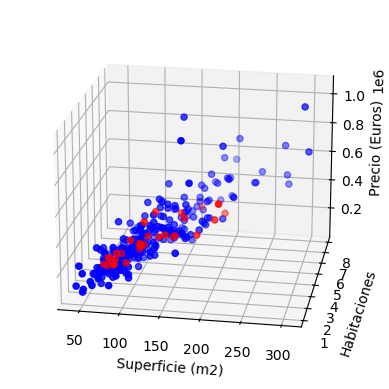

,Label,R2_train,MAE_train,MRE_train,MedAE_train,R2_test,MAE_test,MRE_test,MedAE_test
4,HuberRegresor,0.584668,67717.834971,0.277750,44860.835525,0.586490,53636.919864,0.213221,40620.939548
3,SGDRegressor_huber,0.582697,67717.729142,0.275955,44026.988944,0.584717,53941.064888,0.213634,40832.613255
8,Sequential_keras2,0.594607,68720.786940,0.295444,47052.554688,0.544690,55636.439323,0.231475,37023.351562
9,Poly1,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
1,LinearRegression_multi,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
2,SGDRegressor_sqerr,0.595022,69089.304425,0.298027,48215.875351,0.536754,55256.440825,0.229578,36675.141817
5,MLPRegressor_sck,0.595022,69089.304922,0.298027,48215.890598,0.536754,55256.448041,0.229578,36675.155065
6,Sequential_keras,0.583476,70592.617159,0.317020,53567.046875,0.502870,63503.152604,0.281588,55137.148438
10,Poly2,0.598496,69426.126740,0.297752,48262.625678,0.501577,58375.637686,0.239649,36859.935358
7,MLPRegressor_sck2,0.601002,69171.151342,0.293414,51288.066125,0.478850,59333.388558,0.240543,37975.997767


In [386]:
# Mostramos los datos
    # Dibujar la ecuación del plano de predicción y los puntos de entrenamiento en 3D
    # Código generado con GitHub Copilot
plt.figure()
ax = plt.axes(projection='3d')  # Crear un objeto de tipo Axes3D para dibujar en 3D
ax.scatter(x_train[:,0], x_train[:,1], y_train, c='b', label='Train')
ax.scatter(x_test[:,0], x_test[:,1], y_test, c='r', label='Test')

x1_grid, x2_grid = np.meshgrid(np.linspace(np.min(x_train[:,0]), np.max(x_train[:,0]), 100),
                                    np.linspace(np.min(x_train[:,1]), np.max(x_train[:,1]), 100))

ax.set_xlabel('Superficie (m2)')
ax.set_ylabel('Habitaciones')
ax.set_zlabel('Precio (Euros)')

# Para girar el gráfico 3D
ax.view_init(elev=20, azim=1000)
plt.show()

# Mostramos los resultados
results.sort_values(by='R2_test', ascending=False)

Como conclusión final podemos observar que dada la naturaleza dispersa de los datos y la simplicidad del problema, los modelos de regresión lineal son suficiente para ajustarse a los datos. Esto se observa en que los modelos más complejos como las redes neuronales o la regresión polinómica de grado 2 no mejoran las métricas obtenidas con los modelos de regresión lineal. 

Además, se observa que el modelo de regresión robusta con coste de Huber es el que mejor generaliza a los datos de test. Esto es debido a que el coste de Huber penaliza menos los errores grandes y es por lo tanto es más robusto a datos espurios. Hemos de tener en cuenta que, como ya se ha comentado antes, el modelo de keras con capa oculta en algunas iteraciones puede resultar como el mejor modelo pero en otras puede resultar como el peor. Esto es debido a que el modelo es muy sensible a la inicialización de los pesos y al número de iteraciones. Por lo que no lo consideramos un modelo fiable.

El añadir la segunda variable al modelo de regresión lineal es la mejor mejora que se ha realizado al modelo por lo que si se quiere mejorar el mismo se debería probar añadiendo más variables para ver como evolucionan las métricas.

# Referencias

- https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.

- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html

- https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
- https://www.tensorflow.org/api_docs/python/tf/keras/Sequential







- https://chat.openai.com/chat
- GitHub Copilot
- Transparencias de la asignatura
